In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('spotify-2023.csv', encoding='iso-8859-1')

# Clean Data
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce')
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'], errors='coerce')
df['key'] = df['key'].fillna('Unknown')
df['in_shazam_charts'] = df['in_shazam_charts'].fillna(0)

# Fill NaNs with zero (not sure if necessary)
df.fillna(0, inplace=True)

# Ensure all columns have finite values
df.replace([float('inf'), float('-inf')], 0, inplace=True)

In [4]:
# Key and mode encoding
key_mapping = {
    'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5,
    'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11, 'Unknown': 12
}
df['key_encoded'] = df['key'].map(key_mapping)

mode_mapping = {
    'Minor': 0,
    'Major': 1
}
df['mode_encoded'] = df['mode'].map(mode_mapping)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import accuracy_score, classification_report

# Assuming df is your original dataframe

# Create a copy of the original features
X = df[['danceability_%', 'energy_%', 'acousticness_%', 'liveness_%', 'valence_%', 'bpm', 'key_encoded', 'mode_encoded', 'speechiness_%', 'instrumentalness_%']].copy()

# Log-transform the target variable
y = np.log1p(df['streams'])

# Check for outliers in the target variable
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
y_clean = y[(y >= lower_bound) & (y <= upper_bound)]
X_clean = X.loc[y_clean.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
print("Feature Importances:")
print(importances)
print("---")

# Robust Regression
huber = HuberRegressor()
huber.fit(X_train_scaled, y_train)
y_pred_huber = huber.predict(X_test_scaled)
mse_huber = np.mean((y_test - y_pred_huber)**2)
r2_huber = huber.score(X_test_scaled, y_test)
print("Huber Regression:")
print(f"Mean Squared Error: {mse_huber:.4f}")
print(f"R-squared: {r2_huber:.4f}")
print("---")

# Classification Problem
y_class = (y > y.quantile(0.75)).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train)
y_pred_clf = rf_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_clf)
print("Random Forest Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_clf))

Feature Importances:
              feature  importance
5                 bpm    0.150321
4           valence_%    0.141915
0      danceability_%    0.137303
2      acousticness_%    0.129647
1            energy_%    0.123867
3          liveness_%    0.117735
8       speechiness_%    0.090378
6         key_encoded    0.080817
7        mode_encoded    0.017652
9  instrumentalness_%    0.010365
---
Huber Regression:
Mean Squared Error: 1.1307
R-squared: 0.0184
---
Random Forest Classifier:
Accuracy: 0.7801
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       148
           1       0.60      0.07      0.12        43

    accuracy                           0.78       191
   macro avg       0.69      0.53      0.50       191
weighted avg       0.74      0.78      0.71       191



In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Assuming X and y_class are defined as before

# SMOTE for addressing class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_class)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Engineering
X_train_scaled = np.column_stack((X_train_scaled, X_train_scaled[:, 5]**2))  # Add squared BPM
X_test_scaled = np.column_stack((X_test_scaled, X_test_scaled[:, 5]**2))

# Balanced Random Forest Classifier
brf = BalancedRandomForestClassifier(random_state=42, sampling_strategy='auto', replacement=True, bootstrap=True)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=brf, param_grid=param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("Best parameters:", grid_search.best_params_)
print("Balanced Random Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = pd.DataFrame({'feature': list(X.columns) + ['BPM_squared'],
                            'importance': best_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(importances)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Balanced Random Forest Classifier:
Accuracy: 0.7483
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       143
           1       0.81      0.64      0.72       143

    accuracy                           0.75       286
   macro avg       0.76      0.75      0.75       286
weighted avg       0.76      0.75      0.75       286


Feature Importances:
               feature  importance
4            valence_%    0.126523
8        speechiness_%    0.119362
0       danceability_%    0.115824
2       acousticness_%    0.110759
1             energy_%    0.110511
5                  bpm    0.104326
3           liveness_%    0.094891
10         BPM_squared    0.093527
6          key_encoded    0.074333
7         mode_encoded    0.029134
9   instrumentalness_%    0.020809


In [7]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Feature Engineering
X_ext = X_resampled.copy()
X_ext['valence_dance'] = X_ext['valence_%'] * X_ext['danceability_%']
X_ext['energy_acoustic'] = X_ext['energy_%'] * X_ext['acousticness_%']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_ext, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

y_pred = xgb_model.predict(X_test_scaled)

print("XGBoost Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = pd.DataFrame({'feature': X_ext.columns,
                            'importance': xgb_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(importances)

# Cross-validation
cv_scores = cross_val_score(xgb_model, X_resampled, y_resampled, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

XGBoost Classifier:
Accuracy: 0.7587
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       143
           1       0.74      0.80      0.77       143

    accuracy                           0.76       286
   macro avg       0.76      0.76      0.76       286
weighted avg       0.76      0.76      0.76       286


Feature Importances:
               feature  importance
7         mode_encoded    0.107043
8        speechiness_%    0.101216
9   instrumentalness_%    0.098394
1             energy_%    0.091626
2       acousticness_%    0.090596
11     energy_acoustic    0.080193
5                  bpm    0.079051
4            valence_%    0.074831
10       valence_dance    0.073267
0       danceability_%    0.072830
6          key_encoded    0.066574
3           liveness_%    0.064380

Cross-validation scores: [0.7027972  0.73776224 0.78671329 0.83916084 0.79020979]
Mean CV score: 0.7713


In [8]:
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

# Assuming X_resampled and y_resampled are available from previous code

# Feature Selection
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=8)
X_selected = rfe.fit_transform(X_resampled, y_resampled)
selected_features = X_resampled.columns[rfe.support_]
print("Selected Features:", selected_features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
rf = BalancedRandomForestClassifier(random_state=42, sampling_strategy='auto', replacement=True, bootstrap=True)
xgb = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
lgbm = LGBMClassifier(random_state=42)

# Ensemble
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)], voting='soft')

# Fit ensemble
ensemble.fit(X_train_scaled, y_train)

# Predict
y_pred = ensemble.predict(X_test_scaled)

print("Ensemble Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation
cv_scores = cross_val_score(ensemble, X_selected, y_resampled, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# Hyperparameter Tuning for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb_tuned = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, cv=5, random_state=42, n_jobs=-1)
xgb_tuned.fit(X_train_scaled, y_train)

print("\nBest XGBoost parameters:", xgb_tuned.best_params_)
print(f"Best XGBoost score: {xgb_tuned.best_score_:.4f}")

Selected Features: Index(['danceability_%', 'energy_%', 'acousticness_%', 'liveness_%',
       'valence_%', 'bpm', 'key_encoded', 'speechiness_%'],
      dtype='object')
[LightGBM] [Info] Number of positive: 572, number of negative: 572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 1144, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Ensemble Classifier:
Accuracy: 0.7517
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       143
           1       0.75      0.76      0.75       143

    accuracy                           0.75       286
   macro avg       0.75      0.75      0.75       286
w

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Neural Network Classifier:
Accuracy: 0.7273
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70       143
           1       0.69      0.81      0.75       143

    accuracy                           0.73       286
   macro avg       0.73      0.73      0.73       286
weighted avg       0.73      0.73      0.73       286



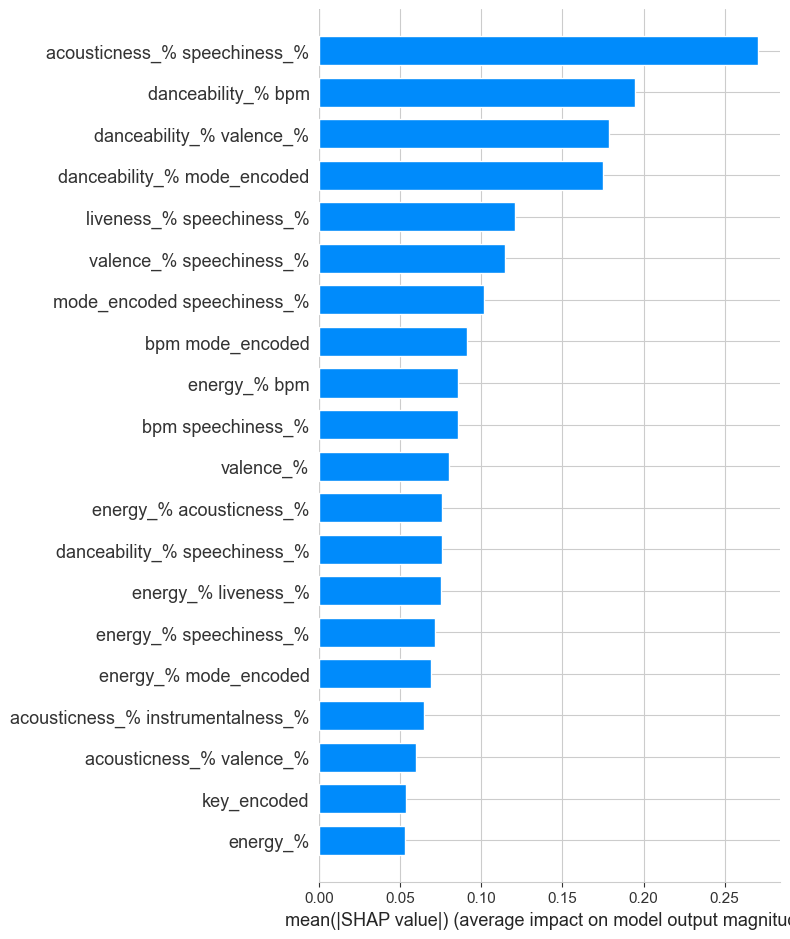


Top 10 features based on SHAP values:
                         feature  importance
32  acousticness_% speechiness_%    0.270643
14            danceability_% bpm    0.195009
13      danceability_% valence_%    0.178743
16   danceability_% mode_encoded    0.174810
38      liveness_% speechiness_%    0.120444
43       valence_% speechiness_%    0.114333
52    mode_encoded speechiness_%    0.101534
46              bpm mode_encoded    0.090898
22                  energy_% bpm    0.085861
47             bpm speechiness_%    0.085689


In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap

# Assuming X_resampled and y_resampled are available from previous code

# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_resampled)

# Use get_feature_names_out instead of get_feature_names
if hasattr(poly, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out(X_resampled.columns)
else:
    feature_names = [f'feature_{i}' for i in range(X_poly.shape[1])]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural Network
nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
nn.fit(X_train_scaled, y_train)

y_pred = nn.predict(X_test_scaled)

print("Neural Network Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# XGBoost
# xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# xgb_model.fit(X_train_scaled, y_train)

from sklearn.ensemble import GradientBoostingClassifier

# XGBoost (using scikit-learn's GradientBoostingClassifier as an alternative)
xgb_model = GradientBoostingClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# SHAP Values for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type="bar")

# Get feature importances based on SHAP values
feature_importance = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names, feature_importance)), columns=['feature', 'importance'])
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 features based on SHAP values:")
print(feature_importance.head(10))

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Create interaction terms based on SHAP insights
X_engineered = X_resampled.copy()
X_engineered['acousticness_speechiness'] = X_resampled['acousticness_%'] * X_resampled['speechiness_%']
X_engineered['danceability_bpm'] = X_resampled['danceability_%'] * X_resampled['bpm']
X_engineered['danceability_valence'] = X_resampled['danceability_%'] * X_resampled['valence_%']
X_engineered['energy_bpm'] = X_resampled['energy_%'] * X_resampled['bpm']
X_engineered['valence_speechiness'] = X_resampled['valence_%'] * X_resampled['speechiness_%']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Create ensemble
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('nn', nn)],
    voting='soft'
)

# Fit the ensemble
ensemble.fit(X_train_scaled, y_train)

# Predict
y_pred = ensemble.predict(X_test_scaled)

print("Ensemble Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Analyze feature importance (using Random Forest as an example)
rf.fit(X_train_scaled, y_train)
feature_importance = pd.DataFrame({
    'feature': X_engineered.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features based on Random Forest importance:")
print(feature_importance.head(10))

Ensemble Classifier:
Accuracy: 0.7413
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       143
           1       0.73      0.77      0.75       143

    accuracy                           0.74       286
   macro avg       0.74      0.74      0.74       286
weighted avg       0.74      0.74      0.74       286


Top 10 features based on Random Forest importance:
                     feature  importance
14       valence_speechiness    0.090349
10  acousticness_speechiness    0.089650
11          danceability_bpm    0.088824
12      danceability_valence    0.086782
4                  valence_%    0.075456
5                        bpm    0.075384
13                energy_bpm    0.073049
1                   energy_%    0.072307
0             danceability_%    0.067403
3                 liveness_%    0.067202


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
import numpy as np

# Assuming X_final and y_resampled are your final feature set and target variable

# Define the models
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
xgb_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
lgbm_model = LGBMClassifier(n_estimators=200, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Define the ensemble
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lgbm', lgbm_model)],
    voting='soft'
)

# List of models to evaluate
models = [
    ("Random Forest", rf_model),
    ("XGBoost", xgb_model),
    ("LightGBM", lgbm_model),
    ("Neural Network", nn_model),
    ("Ensemble", ensemble_model)
]

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    scores = cross_val_score(model, X_final, y_resampled, cv=kf, scoring='accuracy')
    print(f"{name} - Mean CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    # Additional metrics
    precision_scores = cross_val_score(model, X_final, y_resampled, cv=kf, scoring='precision_weighted')
    recall_scores = cross_val_score(model, X_final, y_resampled, cv=kf, scoring='recall_weighted')
    f1_scores = cross_val_score(model, X_final, y_resampled, cv=kf, scoring='f1_weighted')

    print(f"  Precision: {precision_scores.mean():.4f}")
    print(f"  Recall: {recall_scores.mean():.4f}")
    print(f"  F1-score: {f1_scores.mean():.4f}")
    print()

Random Forest - Mean CV Accuracy: 0.7776 (+/- 0.0546)
  Precision: 0.7819
  Recall: 0.7776
  F1-score: 0.7774

XGBoost - Mean CV Accuracy: 0.6958 (+/- 0.0474)
  Precision: 0.7028
  Recall: 0.6958
  F1-score: 0.6954

[LightGBM] [Info] Number of positive: 572, number of negative: 572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1144, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 565, number of negative: 579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number o

In [15]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import numpy as np

# Assuming X_final and y_resampled are your final feature set and target variable

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Balanced Random Forest with updated parameters
brf = BalancedRandomForestClassifier(
    n_estimators=200,
    sampling_strategy='all',
    replacement=True,
    bootstrap=False,
    random_state=42
)
brf_scores = cross_val_score(brf, X_final, y_resampled, cv=kf, scoring='accuracy')

print("Balanced Random Forest:")
print(f"Mean CV Accuracy: {brf_scores.mean():.4f} (+/- {brf_scores.std() * 2:.4f})")

# Additional metrics for Balanced Random Forest
brf_precision = cross_val_score(brf, X_final, y_resampled, cv=kf, scoring='precision_weighted')
brf_recall = cross_val_score(brf, X_final, y_resampled, cv=kf, scoring='recall_weighted')
brf_f1 = cross_val_score(brf, X_final, y_resampled, cv=kf, scoring='f1_weighted')

print(f"Precision: {brf_precision.mean():.4f}")
print(f"Recall: {brf_recall.mean():.4f}")
print(f"F1-score: {brf_f1.mean():.4f}")
print()

# Final Random Forest with selected features
rf_final = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_final_scores = cross_val_score(rf_final, X_final, y_resampled, cv=kf, scoring='accuracy')

print("Final Random Forest (with selected features):")
print(f"Mean CV Accuracy: {rf_final_scores.mean():.4f} (+/- {rf_final_scores.std() * 2:.4f})")

# Additional metrics for Final Random Forest
rf_final_precision = cross_val_score(rf_final, X_final, y_resampled, cv=kf, scoring='precision_weighted')
rf_final_recall = cross_val_score(rf_final, X_final, y_resampled, cv=kf, scoring='recall_weighted')
rf_final_f1 = cross_val_score(rf_final, X_final, y_resampled, cv=kf, scoring='f1_weighted')

print(f"Precision: {rf_final_precision.mean():.4f}")
print(f"Recall: {rf_final_recall.mean():.4f}")
print(f"F1-score: {rf_final_f1.mean():.4f}")

Balanced Random Forest:
Mean CV Accuracy: 0.7895 (+/- 0.0637)
Precision: 0.7933
Recall: 0.7895
F1-score: 0.7892

Final Random Forest (with selected features):
Mean CV Accuracy: 0.7776 (+/- 0.0546)
Precision: 0.7819
Recall: 0.7776
F1-score: 0.7774


Final Model Accuracy: 0.7517

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       143
           1       0.74      0.78      0.76       143

    accuracy                           0.75       286
   macro avg       0.75      0.75      0.75       286
weighted avg       0.75      0.75      0.75       286


Feature Importance:
          feature  importance
0       valence_%    0.188064
3             bpm    0.175156
2        energy_%    0.168614
1  danceability_%    0.166516
4  acousticness_%    0.155638
5   speechiness_%    0.146013


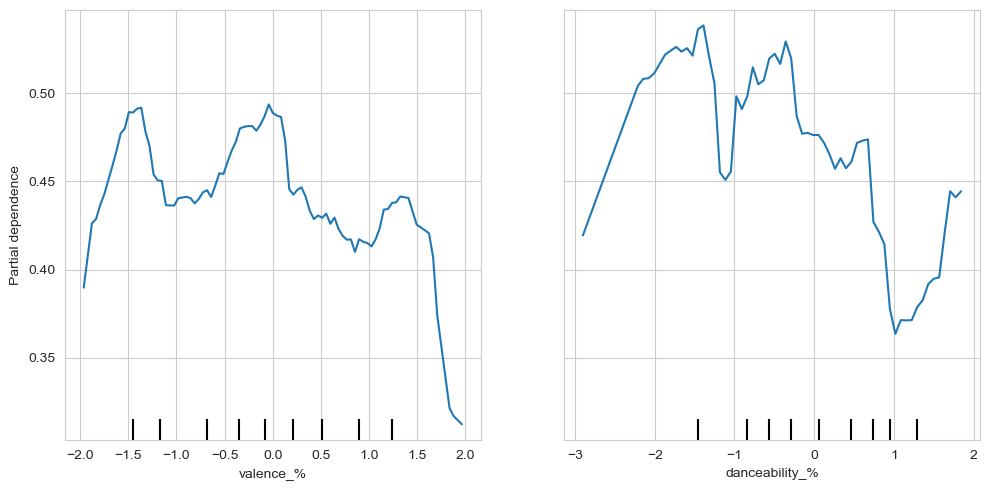

In [11]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import PartialDependenceDisplay

# Assuming X_resampled and y_resampled are your original features and target

# Select top features
top_features = ['valence_%', 'danceability_%', 'energy_%', 'bpm', 'acousticness_%', 'speechiness_%']
X_final = X_resampled[top_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_final, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the final model
final_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': top_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Partial dependence plots for top 2 features
fig, ax = plt.subplots(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(final_model, X_test_scaled, [0, 1], ax=ax, feature_names=top_features)
plt.tight_layout()
plt.show()

GRAPHS

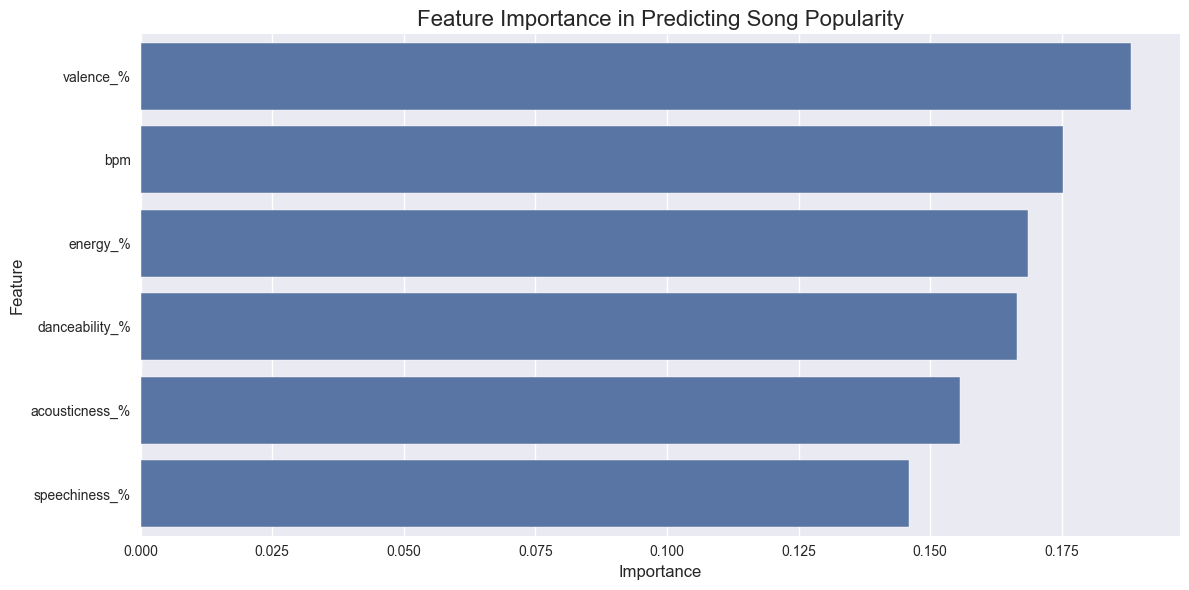

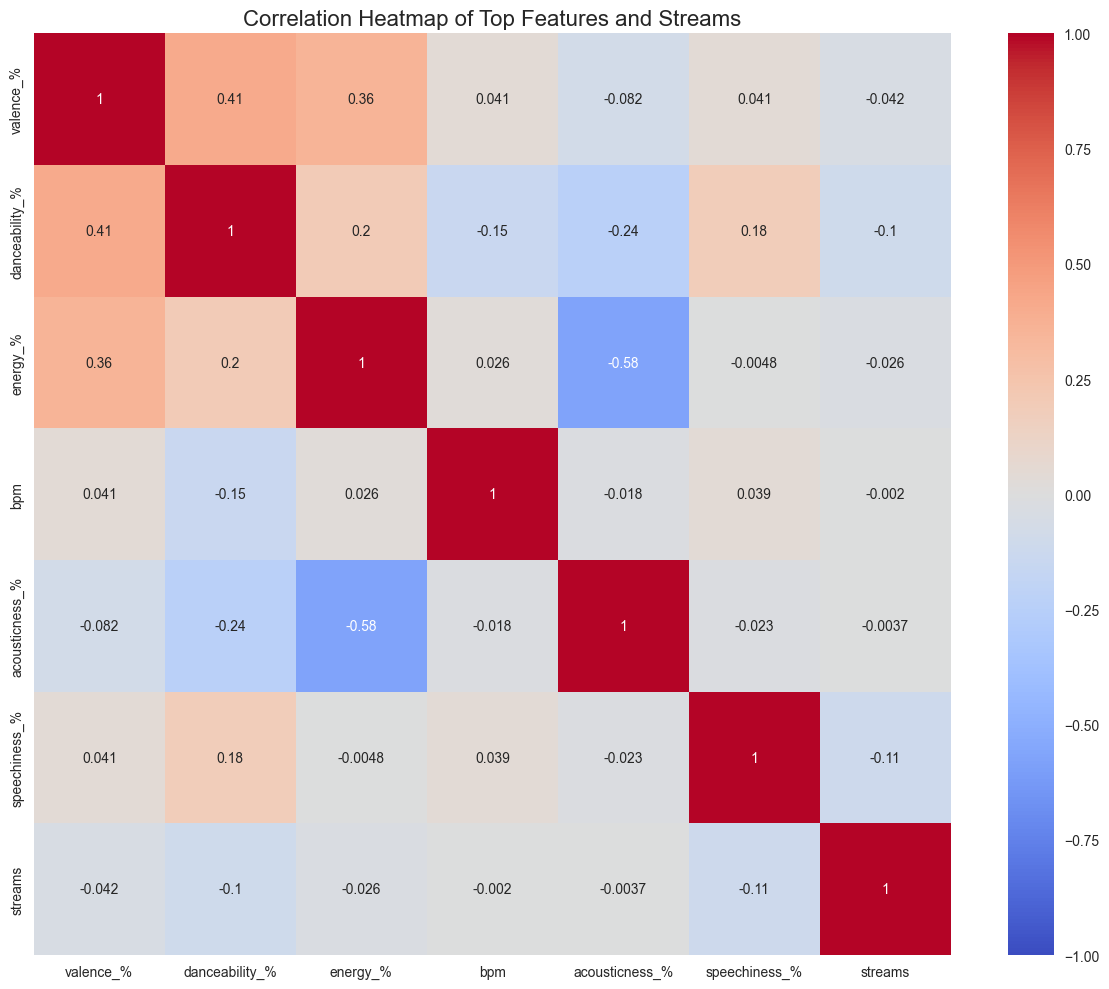

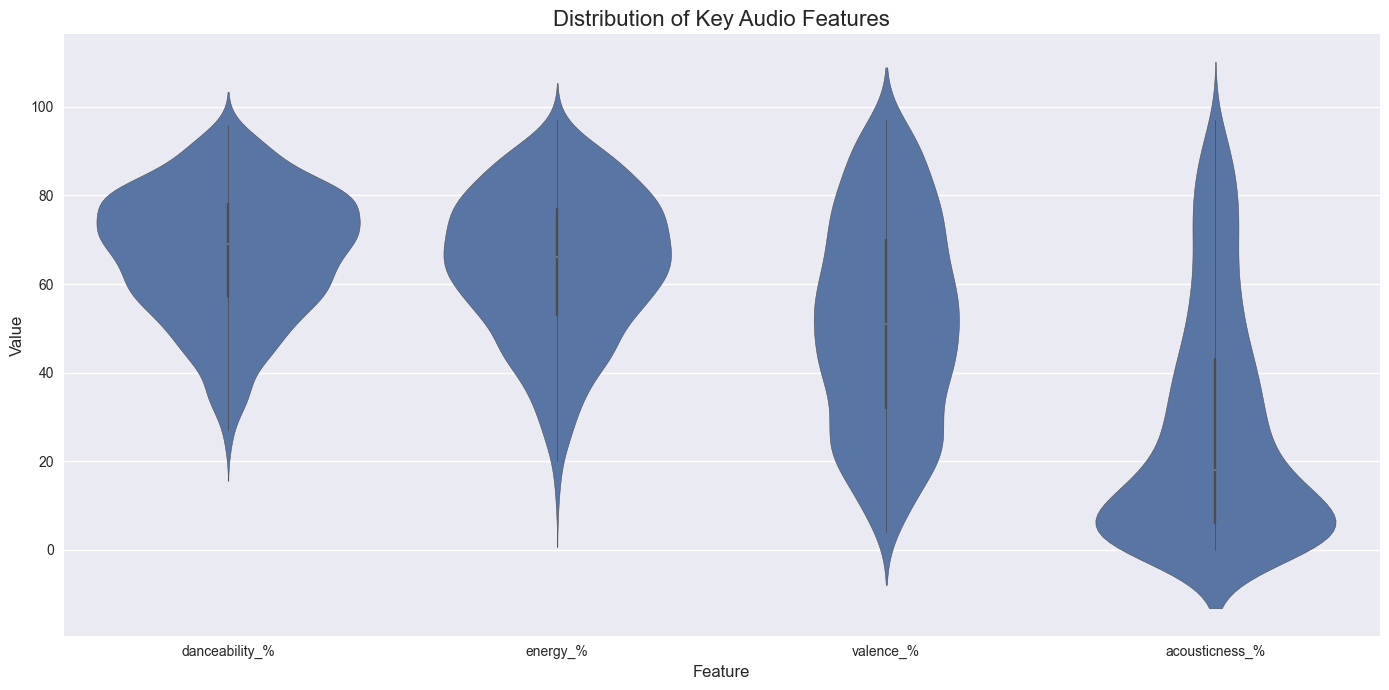

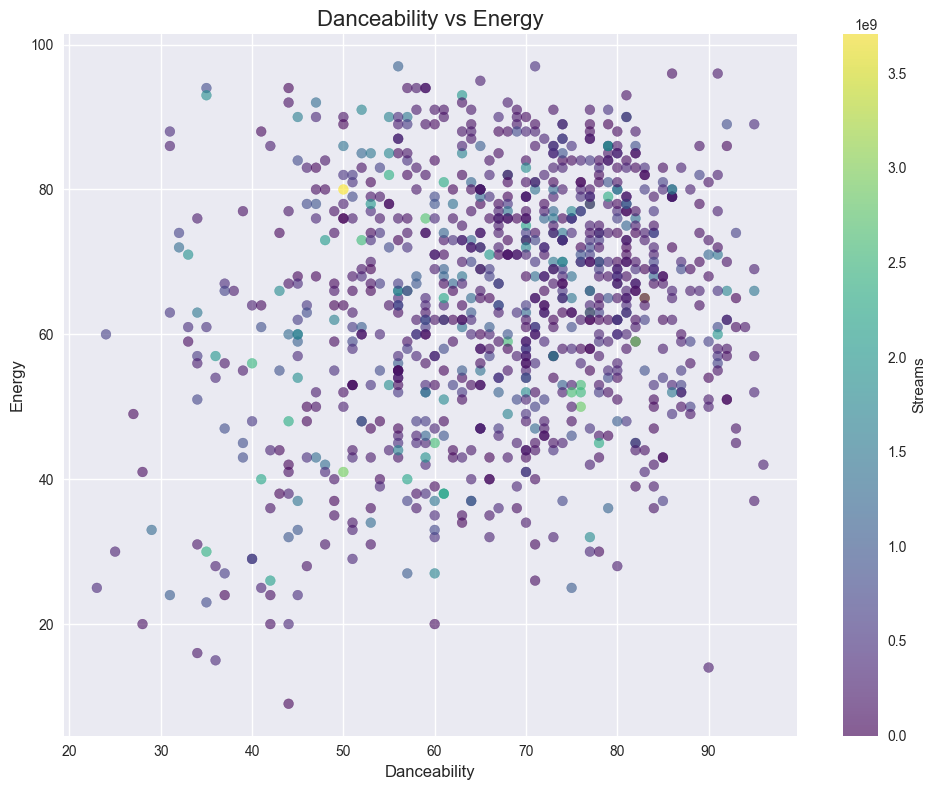

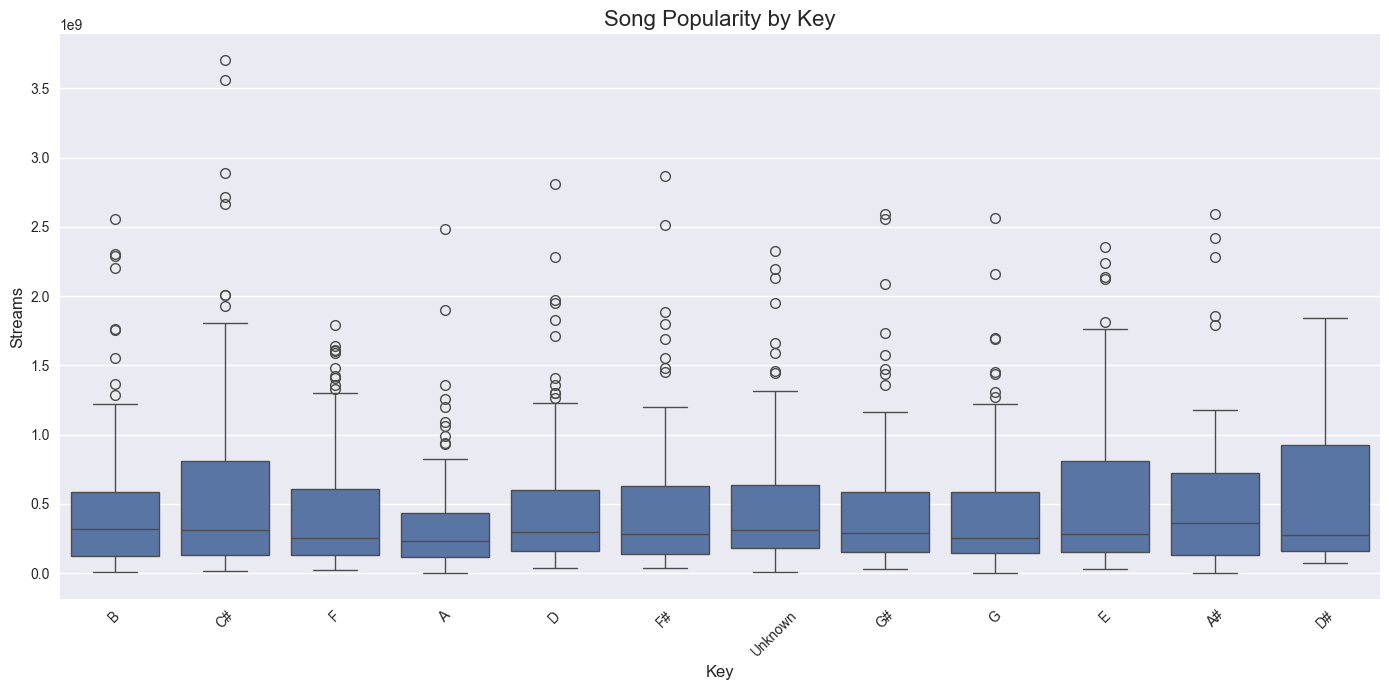

In [17]:

# Define top_features based on your final model
top_features = ['valence_%', 'danceability_%', 'energy_%', 'bpm', 'acousticness_%', 'speechiness_%']

# Set the style for all plots
plt.style.use('seaborn-v0_8')  # Use the v0.8 compatible style
sns.set_palette("deep")

# 1. Feature Importance Plot
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': top_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Song Popularity', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[top_features + ['streams']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Top Features and Streams', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Violin Plot for Audio Features
plt.figure(figsize=(14, 7))
features_to_plot = ['danceability_%', 'energy_%', 'valence_%', 'acousticness_%']
melted_df = pd.melt(df[features_to_plot])
sns.violinplot(x='variable', y='value', data=melted_df)
plt.title('Distribution of Key Audio Features', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.tight_layout()
plt.savefig('audio_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Scatter Plot: Danceability vs Energy (colored by popularity)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['danceability_%'], df['energy_%'], c=df['streams'],
                      cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Streams')
plt.title('Danceability vs Energy', fontsize=16)
plt.xlabel('Danceability', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.tight_layout()
plt.savefig('danceability_vs_energy.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Box Plot: Popularity by Key
plt.figure(figsize=(14, 7))
sns.boxplot(x='key', y='streams', data=df)
plt.title('Song Popularity by Key', fontsize=16)
plt.xlabel('Key', fontsize=12)
plt.ylabel('Streams', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('popularity_by_key.png', dpi=300, bbox_inches='tight')
plt.show()